In [1]:
from scipy.linalg import triu
import numpy as np

a = np.array([[1, 2], [3, 4]])
print(triu(a))


[[1 2]
 [0 4]]


In [2]:
import gensim
from gensim.models import KeyedVectors

print(gensim.__version__)


4.3.2


In [3]:
#노드5번 IMBD 영화리뷰 감성분석 

In [4]:
# IMDb 영화 리뷰 감성 분석을 위한 데이터 심볼릭 링크 생성
#!ln -s /home/jovyan/data /home/jovyan/work/sentiment_classification/  
# /home/jovyan/data 디렉토리를 /home/jovyan/work/sentiment_classification/ 디렉토리로 심볼릭 링크 생성

In [5]:
# 미리 저장된 IMDb 데이터셋을 불러와 활용
import os  # 운영체제 관련 기능을 제공하는 모듈
import numpy as np  # 배열 연산을 위한 라이브러리

# 이번 실습에서는 미리 다운로드된 데이터셋을 불러와 활용하겠습니다
data_dir = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/data/')  # 데이터셋이 저장된 디렉토리 경로 설정

x_train = np.load(data_dir + 'imdb_x_train.npy', allow_pickle=True)  # 훈련용 입력 데이터(리뷰)를 .npy 파일에서 로드
y_train = np.load(data_dir + 'imdb_y_train.npy', allow_pickle=True)  # 훈련용 라벨 데이터(긍정/부정)를 .npy 파일에서 로드
x_test = np.load(data_dir + 'imdb_x_test.npy', allow_pickle=True)  # 테스트용 입력 데이터(리뷰)를 .npy 파일에서 로드
y_test = np.load(data_dir + 'imdb_y_test.npy', allow_pickle=True)  # 테스트용 라벨 데이터(긍정/부정)를 .npy 파일에서 로드
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")  # 로드된 데이터셋의 크기 출력

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [6]:
# IMDb 데이터셋의 첫 번째, 두 번째 리뷰 및 라벨 출력
print(x_train[0])  # 훈련 데이터의 첫 번째 리뷰(정수 시퀀스)를 출력
print('라벨: ', y_train[0])  # 훈련 데이터의 첫 번째 리뷰에 해당하는 라벨(긍정/부정)을 출력
print('1번째 리뷰 문장 길이: ', len(x_train[0]))  # 첫 번째 리뷰의 길이를 출력 (리뷰를 구성하는 단어의 개수)
print('2번째 리뷰 문장 길이: ', len(x_train[1]))  # 두 번째 리뷰의 길이를 출력 (리뷰를 구성하는 단어의 개수)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [7]:
# 단어와 인덱스 매핑 정보를 로드 및 출력
word_to_index = np.load(data_dir + 'imdb_word_to_index.pickle', allow_pickle=True)  # 단어를 정수로 변환하는 딕셔너리 로드
index_to_word = {index:word for word, index in word_to_index.items()}  # 정수를 단어로 변환하는 딕셔너리 생성 (역전환)
print(index_to_word[1])  # 인덱스 1에 해당하는 단어 'the'를 출력
print(word_to_index['the'])  # 단어 'the'에 해당하는 인덱스 1을 출력

the
1


In [8]:
def get_decoded_sentence(data, index_to_word):
    # 인덱스 리스트의 첫 번째 값인 1은 <BOS> 토큰을 의미
    return ' '.join([index_to_word.get(i, '<UNK>') for i in data if i != 1])

In [9]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [10]:
# 인코딩 인덱스 보정 및 특수 토큰 추가
word_to_index = {k:(v+3) for k,v in word_to_index.items()}  # 기존 인덱스를 3씩 뒤로 밀어서 보정

# 처음 4개의 인덱스에 특수 토큰 할당
word_to_index["<PAD>"] = 0  # 패딩 토큰 (문장 길이를 맞추기 위해 사용)
word_to_index["<BOS>"] = 1  # 문장 시작 토큰
word_to_index["<UNK>"] = 2  # 사전에 없는 단어를 나타내는 토큰
word_to_index["<UNUSED>"] = 3  # 사용하지 않는 토큰

index_to_word = {index:word for word, index in word_to_index.items()}  # 보정된 딕셔너리를 역전환하여 새로 생성

print(index_to_word[1])  # 보정 후 인덱스 1에 해당하는 '<BOS>' 출력
print(word_to_index['the'])  # 보정 후 단어 'the'에 해당하는 인덱스 4 출력
print(index_to_word[4])  # 보정 후 인덱스 4에 해당하는 'the' 출력

# 보정 후 첫 번째 리뷰 디코딩
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [11]:
# 첫 번째 리뷰를 디코딩하고 라벨 출력
print(get_decoded_sentence(x_train[0], index_to_word))  # 숫자 인덱스로 된 첫 번째 리뷰를 단어 문장으로 변환하여 출력
print('라벨: ', y_train[0])  # 첫 번째 리뷰의 감성 라벨(0: 부정, 1: 긍정) 출력

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [12]:
# IMDb 데이터셋의 문장 길이 분석 및 최대 길이 설정
total_data_text = list(x_train) + list(x_test)  # 훈련 데이터와 테스트 데이터를 하나로 합침

# 각 문장의 토큰(단어) 개수를 리스트로 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)  # 계산을 위해 numpy 배열로 변환

# 문장 길이 통계 출력
print('문장길이 평균 : ', np.mean(num_tokens))  # 문장 길이의 평균값
print('문장길이 최대 : ', np.max(num_tokens))  # 문장 길이의 최댓값
print('문장길이 표준편차 : ', np.std(num_tokens))  # 문장 길이의 표준편차

# 최대 문장 길이(maxlen)를 평균 + 2*표준편차로 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)  # 정수형으로 변환
print('pad_sequences maxlen : ', maxlen)

# 설정된 maxlen에 포함되는 문장 비율 계산 및 출력
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [13]:
# 문장 길이 통일 및 텐서 변환
import torch

def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            # 문장 길이가 maxlen보다 짧으면, 0(패딩)을 추가하여 길이 맞추기
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            # 문장 길이가 maxlen보다 길면, 뒷부분을 잘라서 길이 맞추기
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)  # 결과를 numpy 배열로 반환

x_train_padded = pad_sequences(x_train, maxlen)  # 훈련 데이터의 길이를 maxlen에 맞춤
x_test_padded = pad_sequences(x_test, maxlen)  # 테스트 데이터의 길이를 maxlen에 맞춤

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)  # 패딩된 훈련 데이터를 PyTorch 텐서로 변환
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)  # 패딩된 테스트 데이터를 PyTorch 텐서로 변환

print(x_train_tensor.shape)  # 변환된 훈련 텐서의 형태(shape) 출력

torch.Size([25000, 580])


In [14]:
# PyTorch를 이용한 LSTM 기반 감성 분석 모델 정의 및 구조 출력
import torch  # 딥러닝 프레임워크 PyTorch 라이브러리
import torch.nn as nn  # 신경망 모듈
import torch.nn.functional as F  # 신경망 함수 모음

vocab_size = 10000  # 모델이 다룰 수 있는 단어의 총 개수
word_vector_dim = 16  # 각 단어를 표현하는 워드 벡터의 차원

# 모델 설계: nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    # 모델의 레이어(Layer)들을 정의
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어를 워드 벡터로 변환하는 임베딩 레이어
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)  # 워드 벡터 시퀀스를 처리하는 LSTM 레이어
        self.fc1 = nn.Linear(8, 8)  # LSTM의 최종 출력을 받아서 처리하는 첫 번째 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력을 0과 1 사이의 값으로 만드는 두 번째 완전 연결 레이어

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 임베딩 레이어에 통과시켜 워드 벡터로 변환
        x, (hn, cn) = self.lstm(x)  # 임베딩 벡터 시퀀스를 LSTM에 통과
        x = x[:, -1, :]  # LSTM의 최종 시점(sequence의 마지막)의 은닉 상태를 가져옴
        x = F.relu(self.fc1(x))  # 첫 번째 완전 연결 레이어에 통과시키고 ReLU 활성화 함수 적용
        x = torch.sigmoid(self.fc2(x))  # 두 번째 완전 연결 레이어에 통과시키고 시그모이드 활성화 함수 적용 (0~1 사이 값)
        return x  # 최종 출력값 반환

model = SentimentModel(vocab_size, word_vector_dim)  # 정의된 클래스를 바탕으로 모델 객체 생성
print(model)  # 모델의 레이어 구조와 파라미터 정보 출력

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [15]:
# 훈련 데이터셋을 훈련용과 검증용으로 분리
# validation set 10000건 분리
x_val = x_train_tensor[:10000]  # x_train_tensor의 앞 10,000개를 검증용 입력 데이터로 할당
y_val = y_train[:10000]  # y_train의 앞 10,000개를 검증용 라벨 데이터로 할당

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]  # x_train_tensor의 10,000번째 이후 데이터를 훈련용 입력 데이터로 할당
partial_y_train = y_train[10000:]  # y_train의 10,000번째 이후 데이터를 훈련용 라벨 데이터로 할당

print(partial_x_train.shape)  # 재할당된 훈련용 입력 데이터의 형태(shape) 출력
print(partial_y_train.shape)  # 재할당된 훈련용 라벨 데이터의 형태(shape) 출력

torch.Size([15000, 580])
(15000,)


In [16]:
# PyTorch를 이용한 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
import torch.nn.functional as F  # 활성화 함수, 손실 함수 등
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

optimizer = optim.Adam(model.parameters())  # 모델의 파라미터를 업데이트할 Adam 최적화 도구 설정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)  # 훈련용 입력 데이터를 PyTorch 텐서로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)  # 검증용 입력 데이터를 PyTorch 텐서로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 30  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

for epoch in range(epochs):
    # 훈련 단계 시작
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0  # 현재 에포크의 누적 손실 초기화
    correct = 0  # 현재 에포크의 정답 수 초기화
    total = 0  # 현재 에포크의 전체 데이터 수 초기화

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()  # 현재 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
        total += labels.size(0)  # 전체 데이터 수 누적

    train_losses.append(running_loss / len(train_loader))  # 에포크별 평균 훈련 손실 기록
    train_accs.append(correct / total)  # 에포크별 훈련 정확도 기록

    # 검증 단계 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0  # 현재 에포크의 누적 검증 손실 초기화
    val_correct = 0  # 현재 에포크의 정답 수 초기화
    val_total = 0  # 현재 에포크의 전체 데이터 수 초기화

    with torch.no_grad():  # 기울기 계산을 비활성화 (메모리 절약, 연산 속도 향상)
        for inputs, labels in val_loader:
            outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
            loss = loss_fn(outputs.squeeze(), labels)  # 손실 계산

            val_loss += loss.item()  # 현재 배치 손실을 누적
            predicted = (outputs.squeeze() > 0.5).float()  # 예측값 기반으로 정답 판단
            val_correct += (predicted == labels).sum().item()  # 맞춘 개수 누적
            val_total += labels.size(0)  # 전체 데이터 수 누적

    val_losses.append(val_loss / len(val_loader))  # 에포크별 평균 검증 손실 기록
    val_accs.append(val_correct / val_total)  # 에포크별 검증 정확도 기록

    # 에포크별 결과 출력
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_1221/1080973660.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)  # 훈련용 입력 데이터를 PyTorch 텐서로 변환
/tmp/ipykernel_1221/1080973660.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)  # 검증용 입력 데이터를 PyTorch 텐서로 변환


Epoch 1/30 - Train Loss: 0.7033, Train Accuracy: 0.4965 - Validation Loss: 0.6977, Validation Accuracy: 0.5053
Epoch 2/30 - Train Loss: 0.6986, Train Accuracy: 0.4965 - Validation Loss: 0.6953, Validation Accuracy: 0.5053
Epoch 3/30 - Train Loss: 0.6953, Train Accuracy: 0.4965 - Validation Loss: 0.6933, Validation Accuracy: 0.5053
Epoch 4/30 - Train Loss: 0.6932, Train Accuracy: 0.4947 - Validation Loss: 0.6930, Validation Accuracy: 0.5010
Epoch 5/30 - Train Loss: 0.6928, Train Accuracy: 0.5089 - Validation Loss: 0.6931, Validation Accuracy: 0.5007
Epoch 6/30 - Train Loss: 0.6926, Train Accuracy: 0.5090 - Validation Loss: 0.6931, Validation Accuracy: 0.5007
Epoch 7/30 - Train Loss: 0.6927, Train Accuracy: 0.5089 - Validation Loss: 0.6931, Validation Accuracy: 0.5007
Epoch 8/30 - Train Loss: 0.6927, Train Accuracy: 0.5089 - Validation Loss: 0.6931, Validation Accuracy: 0.5006
Epoch 9/30 - Train Loss: 0.6925, Train Accuracy: 0.5089 - Validation Loss: 0.6931, Validation Accuracy: 0.5007
E

In [17]:
# 훈련된 모델의 성능을 테스트 데이터셋으로 평가
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))  # 테스트 데이터와 라벨을 PyTorch 데이터셋으로 묶음
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)  # 테스트 데이터셋을 효율적으로 로드하기 위한 데이터로더 생성

model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등의 동작을 멈춤)
test_loss = 0.0  # 테스트 손실 합계를 초기화
test_correct = 0  # 맞춘 정답 개수를 초기화
test_total = 0  # 전체 테스트 데이터 개수를 초기화

with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리와 연산 효율 최적화
    for inputs, labels in test_loader:
        outputs = model(inputs)  # 모델에 테스트 데이터를 입력하여 예측값 생성
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산

        test_loss += loss.item()  # 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        test_correct += (predicted == labels).sum().item()  # 예측이 맞은 개수를 누적
        test_total += labels.size(0)  # 전체 테스트 데이터 개수를 누적

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")  # 최종 평균 손실과 정확도 출력

Test Loss: 0.7285, Test Accuracy: 0.5057


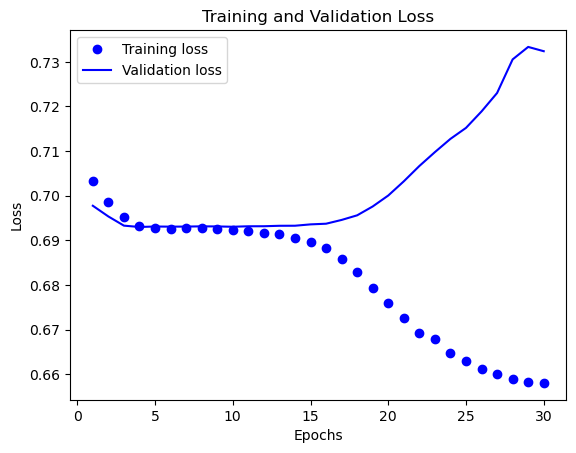

In [18]:
# 훈련 및 검증 손실 시각화
import matplotlib.pyplot as plt  # 그래프를 그리는 라이브러리

epochs_range = range(1, epochs + 1)  # 그래프의 x축이 될 에포크 범위를 생성

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')  # 에포크별 훈련 손실을 파란색 점으로 표시
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')  # 에포크별 검증 손실을 파란색 실선으로 표시
plt.title('Training and Validation Loss')  # 그래프의 제목 설정
plt.xlabel('Epochs')  # x축의 라벨 설정
plt.ylabel('Loss')  # y축의 라벨 설정
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력

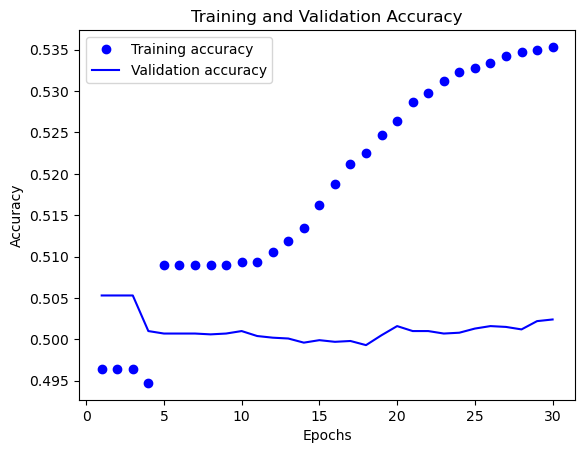

In [19]:
# 훈련 및 검증 정확도 시각화
plt.clf()  # 이전에 그린 그래프를 초기화

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')  # 에포크별 훈련 정확도를 파란색 점으로 표시
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')  # 에포크별 검증 정확도를 파란색 실선으로 표시
plt.title('Training and Validation Accuracy')  # 그래프의 제목 설정
plt.xlabel('Epochs')  # x축의 라벨 설정
plt.ylabel('Accuracy')  # y축의 라벨 설정
plt.legend()  # 범례 표시
plt.show()  # 그래프 출력

In [20]:
# 워드 벡터 저장 디렉토리 생성 및 관련 패키지 설치
!mkdir -p sentiment_classification/data  # 워드 벡터 파일을 저장할 디렉토리를 생성. -p 옵션은 상위 디렉토리가 없으면 함께 생성함.
!pip install gensim==4.3.2  # 워드 임베딩을 다루는 데 사용되는 gensim 라이브러리 설치 (버전 4.3.2 지정)
!pip install scipy==1.12.0 numpy==1.26.3  # gensim의 종속성(dependency)인 scipy와 numpy 라이브러리 설치 (각각 특정 버전 지정)

  Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy-1.26.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached scipy-1.12.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.8 MB)
Using cached numpy-1.26.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]
    Found existing installation: scipy 1.11.4 0/2 [numpy]
    Uninstalling scipy-1.11.4:━━━━━━━━━━━━━━ 0/2 [numpy]
      Successfully uninstalled scipy-1.11.4━━━━━━━━━━━━━━━━━━━ 1/2 [scipy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]32m1/2 [scipy]


In [21]:
# 워드 벡터 저장용 디렉토리 생성
!mkdir ~/work/sentiment_classification/word2vec_emb  # 사용자의 홈 디렉토리 내에 워드 벡터 저장용 디렉토리를 생성

mkdir: cannot create directory ‘/home/jovyan/work/sentiment_classification/word2vec_emb’: File exists


In [22]:
# 모델에서 학습된 워드 벡터를 텍스트 파일로 저장
word2vec_file_path = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/word2vec_emb/word2vec.txt')  # 저장할 파일의 전체 경로 설정

with open(word2vec_file_path, 'w') as f:  # 'w' (쓰기) 모드로 파일을 열고 f 객체에 할당
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 파일의 첫 줄에 전체 단어 수(특수 토큰 4개 제외)와 벡터 차원을 기록

    # 훈련된 모델의 Embedding 레이어에서 워드 벡터 가져오기
    vectors = model.embedding.weight.detach().cpu().numpy()  # 모델의 임베딩 가중치를 numpy 배열로 변환

    # 특수 토큰을 제외한 모든 단어의 워드 벡터를 파일에 기록
    for i in range(4, vocab_size):  # 인덱스 4부터 시작하여 모든 단어에 대해 반복
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))  # "단어 워드벡터값" 형식으로 한 줄씩 파일에 작성

In [23]:
!pip install konlpy

In [25]:
# Word2VecKeyedVectors를 사용하여 'computer' 단어의 워드 벡터 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors  # Word2Vec 모델의 핵심인 KeyedVectors 모듈을 불러옴

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)  # 저장된 텍스트 파일을 불러와 Word2VecKeyedVectors 객체 생성
vector = word_vectors['computer']  # 'computer' 단어에 해당하는 벡터를 가져와서 vector 변수에 할당
vector  # vector 변수의 값을 출력하여 벡터 값 확인

array([-1.9215647 ,  0.04042735, -1.1951156 , -0.39904854, -1.7748142 ,
       -1.0953999 ,  0.25793186,  0.90044105, -1.7142733 ,  0.9581672 ,
        1.1075758 , -1.111144  ,  0.5457934 , -1.0159205 , -0.17271557,
        0.04986871], dtype=float32)

In [26]:
# 'love'와 가장 유사한 단어 찾기
word_vectors.similar_by_word("love")  # Word2VecKeyedVectors 객체의 similar_by_word 메서드를 사용해 'love'와 유사한 단어들을 반환

[('affecting', 0.8433532118797302),
 ('unit', 0.7949129939079285),
 ('hired', 0.7716190218925476),
 ('convincing', 0.7549298405647278),
 ('carpet', 0.7421450018882751),
 ('christmas', 0.7362399101257324),
 ('groove', 0.733951985836029),
 ('luckily', 0.7081587910652161),
 ('author', 0.7050560116767883),
 ('open', 0.6996666193008423)]

In [28]:
# 다운로드한 Google Word2Vec 모델 파일을 작업 디렉토리로 이동
# ! mv ~/Downloads/GoogleNews-vectors-negative300.bin.gz ~/work/sentiment_classification  # GoogleNews-vectors... 파일을 사용자의 다운로드 폴더에서 sentiment_classification 폴더로 이동

mv: cannot stat '/home/jovyan/Downloads/GoogleNews-vectors-negative300.bin.gz': No such file or directory


In [29]:
# 사전 학습된 Google Word2Vec 모델 로드
from gensim.models import KeyedVectors  # Word2Vec 벡터를 다루는 데 필요한 KeyedVectors 모듈 임포트

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'  # Google Word2Vec 모델 파일 경로 설정
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)  # 지정된 경로의 바이너리 파일을 불러옴
vector = word2vec['computer']  # 불러온 모델에서 'computer' 단어의 벡터를 가져와서 vector 변수에 할당
vector  # vector 변수에 저장된 벡터 값 출력

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [30]:
# 'love' 단어와 유사한 단어 찾기
word2vec.similar_by_word("love")  # 사전 학습된 word2vec 모델에서 'love'와 가장 유사한 단어들을 유사도 점수와 함께 반환

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [31]:
# Google Word2Vec 모델의 워드 벡터를 embedding_matrix에 복사
vocab_size = 10000  # 모델이 사용할 총 단어의 개수
word_vector_dim = 300  # 워드 벡터의 차원 (Google Word2Vec과 동일하게 300으로 설정)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)  # 임의의 값으로 초기화된 임베딩 행렬 생성

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4, vocab_size):  # 단어 인덱스 4부터 시작하여 모든 단어에 대해 반복
    if index_to_word[i] in word2vec:  # 현재 단어가 Google Word2Vec 모델에 포함되어 있는지 확인
        embedding_matrix[i] = word2vec[index_to_word[i]]  # 포함되어 있다면, 해당 단어의 워드 벡터를 embedding_matrix의 i번째 행에 복사

In [33]:
# 사전 학습된 워드 벡터를 사용하는 CNN 기반 감성 분석 모델 정의 및 구조 출력
import torch
import torch.nn as nn
import torch.nn.functional as F

# 모델 설계 - nn.Module을 상속받아 SentimentModel 클래스 정의
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()  # nn.Module의 생성자 호출
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)  # 단어 임베딩 레이어 정의
        #self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))  # 사전 학습된 워드 벡터를 임베딩 레이어의 가중치로 설정
        self.embedding.weight = nn.Parameter(embedding_matrix.detach().clone())
        self.embedding.weight.requires_grad = True  # 임베딩 가중치 업데이트를 허용

        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)  # 첫 번째 1D 합성곱 레이어
        self.pool = nn.MaxPool1d(kernel_size=5)  # 최대 풀링 레이어
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)  # 두 번째 1D 합성곱 레이어
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)  # 전체 문장에서 가장 중요한 특징을 추출하는 글로벌 최대 풀링 레이어
        self.fc1 = nn.Linear(16, 8)  # 완전 연결 레이어
        self.fc2 = nn.Linear(8, 1)  # 최종 출력 레이어 (이진 분류)

    # 모델의 순전파(forward) 로직을 정의
    def forward(self, x):
        x = self.embedding(x)  # 입력(단어 인덱스)을 워드 벡터로 변환 (batch, maxlen, word_vector_dim)
        x = x.permute(0, 2, 1)  # CNN 처리를 위해 텐서 차원 변경 (batch, word_vector_dim, maxlen)
        x = F.relu(self.conv1(x))  # 첫 번째 Conv1d 레이어와 ReLU 활성화 함수 통과
        x = self.pool(x)  # MaxPool1d 레이어 통과
        x = F.relu(self.conv2(x))  # 두 번째 Conv1d 레이어와 ReLU 활성화 함수 통과
        x = self.global_max_pool(x).squeeze(2)  # GlobalMaxPool1d를 적용하여 1차원 벡터로 변환
        x = F.relu(self.fc1(x))  # 완전 연결 레이어와 ReLU 활성화 함수 통과
        x = torch.sigmoid(self.fc2(x))  # 최종 완전 연결 레이어와 시그모이드 활성화 함수 통과 (0~1)
        return x

vocab_size = 10000
word_vector_dim = 300
embedding_matrix = torch.randn(vocab_size, word_vector_dim)  # 임의의 값으로 임베딩 행렬 생성 (실제로는 Word2Vec으로 초기화)

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)  # 모델 객체 생성
print(model)  # 모델의 레이어 구조 출력

SentimentModel(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [34]:
# CNN 기반 감성 분석 모델 훈련
import torch.optim as optim  # 최적화 도구 모음
from torch.utils.data import DataLoader, TensorDataset  # 데이터 로딩 유틸리티

optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화 도구 설정. 학습률(lr) 0.001 지정
loss_fn = torch.nn.BCELoss()  # 이진 분류에 적합한 Binary Cross Entropy 손실 함수 설정

partial_x_train_tensor = partial_x_train.detach().clone().to(torch.long)
#partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
# 훈련용 입력 데이터를 PyTorch 텐서로 변환
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)  # 훈련용 라벨 데이터를 PyTorch 텐서로 변환 (BCELoss를 위해 float 타입 사용)

x_val_tensor = x_val.detach().clone().to(torch.long)
#x_val_tensor = torch.tensor(x_val, dtype=torch.long)  # 검증용 입력 데이터를 PyTorch 텐서로 변환
y_val_tensor = torch.tensor(y_val, dtype=torch.float)  # 검증용 라벨 데이터를 PyTorch 텐서로 변환

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)  # 훈련 데이터와 라벨을 묶어 데이터셋 생성
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)  # 검증 데이터와 라벨을 묶어 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # 훈련용 데이터로더 생성 (배치 크기 512, 데이터 섞기)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)  # 검증용 데이터로더 생성 (배치 크기 512, 데이터 섞지 않음)

epochs = 20  # 훈련 반복 횟수 설정
train_losses = []  # 에포크별 훈련 손실을 저장할 리스트
val_losses = []  # 에포크별 검증 손실을 저장할 리스트
train_accs = []  # 에포크별 훈련 정확도를 저장할 리스트
val_accs = []  # 에포크별 검증 정확도를 저장할 리스트

for epoch in range(epochs):
    # 훈련 단계
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # 이전 스텝에서 계산된 기울기 초기화

        outputs = model(inputs)  # 모델에 입력 데이터를 넣어 예측값 계산
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산
        loss.backward()  # 손실에 대한 기울기 역전파
        optimizer.step()  # 모델의 파라미터 업데이트

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # 검증 단계
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # 기울기 계산을 비활성화
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_1221/3059198656.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)  # 훈련용 입력 데이터를 PyTorch 텐서로 변환
/tmp/ipykernel_1221/3059198656.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)  # 검증용 입력 데이터를 PyTorch 텐서로 변환


Epoch 1/20 - Train Loss: 0.6902, Train Accuracy: 0.5318 - Validation Loss: 0.6819, Validation Accuracy: 0.6001
Epoch 2/20 - Train Loss: 0.6546, Train Accuracy: 0.6555 - Validation Loss: 0.6364, Validation Accuracy: 0.6483
Epoch 3/20 - Train Loss: 0.5596, Train Accuracy: 0.7311 - Validation Loss: 0.5212, Validation Accuracy: 0.7494
Epoch 4/20 - Train Loss: 0.4244, Train Accuracy: 0.8155 - Validation Loss: 0.4349, Validation Accuracy: 0.8016
Epoch 5/20 - Train Loss: 0.3239, Train Accuracy: 0.8663 - Validation Loss: 0.3979, Validation Accuracy: 0.8170
Epoch 6/20 - Train Loss: 0.2414, Train Accuracy: 0.9118 - Validation Loss: 0.3755, Validation Accuracy: 0.8313
Epoch 7/20 - Train Loss: 0.1799, Train Accuracy: 0.9418 - Validation Loss: 0.3758, Validation Accuracy: 0.8374
Epoch 8/20 - Train Loss: 0.1285, Train Accuracy: 0.9631 - Validation Loss: 0.3960, Validation Accuracy: 0.8374
Epoch 9/20 - Train Loss: 0.0910, Train Accuracy: 0.9803 - Validation Loss: 0.3928, Validation Accuracy: 0.8411
E

In [38]:
# 훈련된 모델의 성능을 테스트 데이터셋으로 평가
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

model.eval()  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 등의 동작을 멈춤)
test_loss = 0.0  # 테스트 손실 합계를 초기화
test_correct = 0  # 맞춘 정답 개수를 초기화
test_total = 0  # 전체 테스트 데이터 개수를 초기화


# ① x_test를 torch 텐서 리스트로 변환
x_test_tensor_list = [torch.tensor(seq, dtype=torch.long) for seq in x_test]

# ② 시퀀스 길이를 맞추기 위해 패딩 (batch_size, max_len 형태)
x_test_padded = pad_sequence(x_test_tensor_list, batch_first=True, padding_value=0)

# ③ y_test를 텐서로 변환
y_test_tensor = torch.tensor(y_test, dtype=torch.float)

# ④ TensorDataset과 DataLoader 생성
test_dataset = TensorDataset(x_test_padded, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# x_test_tensor = torch.tensor(x_test, dtype=torch.long)  # 테스트용 입력 데이터를 PyTorch 텐서로 변환
# y_test_tensor = torch.tensor(y_test, dtype=torch.float)  # 테스트용 라벨 데이터를 PyTorch 텐서로 변환
# test_dataset = TensorDataset(x_test_tensor, y_test_tensor)  # 테스트 데이터와 라벨을 PyTorch 데이터셋으로 묶음
# test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)  # 테스트 데이터셋을 효율적으로 로드하기 위한 데이터로더 생성

with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리와 연산 효율 최적화
    for inputs, labels in test_loader:
        outputs = model(inputs)  # 모델에 테스트 데이터를 입력하여 예측값 생성
        loss = loss_fn(outputs.squeeze(), labels)  # 예측값과 실제 라벨 간의 손실 계산

        test_loss += loss.item()  # 배치 손실을 누적
        predicted = (outputs.squeeze() > 0.5).float()  # 예측값이 0.5보다 크면 긍정(1), 아니면 부정(0)으로 판단
        test_correct += (predicted == labels).sum().item()  # 예측이 맞은 개수를 누적
        test_total += labels.size(0)  # 전체 테스트 데이터 개수를 누적

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")  # 최종 평균 손실과 정확도 출력

Test Loss: 0.6071, Test Accuracy: 0.8455
